In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from pptx import Presentation
from pptx.util import Inches
from io import BytesIO
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
import os
from adjustText import adjust_text


In [2]:
results_df = pd.read_csv("results/test_results.csv")

# Define log params column
results_df['log_params'] = np.log( results_df['params'] )

# Filter only for Kaggle Expanded TB data for internal (it performed better than the reverse)
results_df = results_df[results_df['internal_data'] == 'kaggle_expanded_tb']

# Drop any rows that are all NA
results_df.dropna(how='all', inplace=True)

# Convert Truncated Layers to Int
results_df['truncated_layers'] = results_df['truncated_layers'].apply(lambda x: int(x))

In [3]:
results_df['model_label'] = results_df['truncated_layers'].apply(lambda x: f"B0(-{x})")


## Internal Accuracy vs Log Params

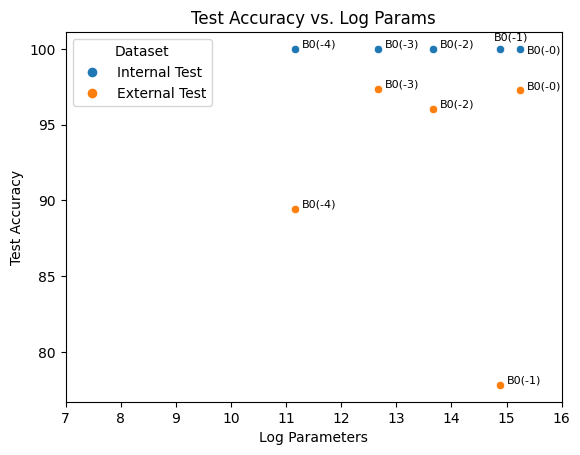

In [4]:
# Create figure and axis
fig1, ax1 = plt.subplots()

sns.scatterplot(x='log_params', y='single_test_acc', data=results_df, color='#1f77b4')
sns.scatterplot(x='log_params', y='external_test_acc', data=results_df, color='#ff7f0e')

# Add plot labels 
ax1.set_title("Test Accuracy vs. Log Params")
ax1.set_ylabel("Test Accuracy")
ax1.set_xlabel("Log Parameters")

ax1.set_xlim([7, 16])

nrow = results_df.shape[0]

# Define text labels and adjust them
texts1 = []
for i in range(nrow):
    texts1.append(ax1.text(x=results_df['log_params'].iloc[i] + 0.1, y=results_df['single_test_acc'].iloc[i], 
                          s=results_df['model_label'].iloc[i], fontsize = 8))
    texts1.append(ax1.text(x=results_df['log_params'].iloc[i] + 0.1, y=results_df['external_test_acc'].iloc[i], 
                          s=results_df['model_label'].iloc[i], fontsize = 8))

# Adjust text positions to avoid overlap
adjust_text(texts1, ax=ax1)

# Add legend manually
legend_labels = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#1f77b4', markersize=8, label='Internal Test'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#ff7f0e', markersize=8, label='External Test')
]
ax1.legend(handles=legend_labels, title="Dataset")

# Save to png
fig1.savefig("paper_figs/accuracy_vs_params.png", format='png')

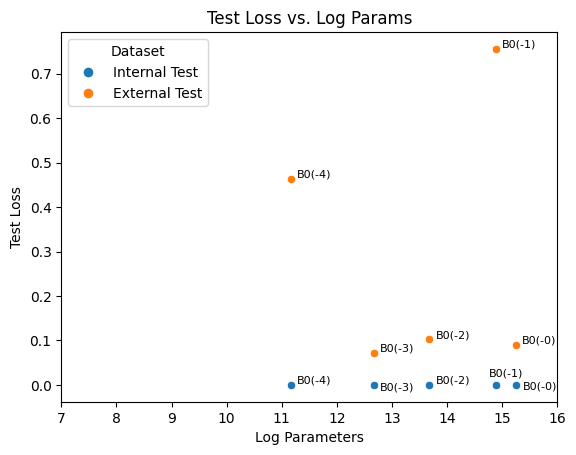

In [5]:
# Plot internal test accuracy by log params

# Create figure and axis
fig2, ax2 = plt.subplots()

sns.scatterplot(x='log_params', y='single_test_loss', data=results_df, color='#1f77b4')
sns.scatterplot(x='log_params', y='external_test_loss', data=results_df, color='#ff7f0e')

# Add plot labels 
ax2.set_title("Test Loss vs. Log Params")
ax2.set_ylabel("Test Loss")
ax2.set_xlabel("Log Parameters")

ax2.set_xlim([7, 16])

# Define number of rows value for plotting labels
n_row = results_df.shape[0]

texts2 = []
for i in range(nrow):
    texts2.append(ax2.text(x=results_df['log_params'].iloc[i] + 0.1, y=results_df['single_test_loss'].iloc[i], 
                          s=results_df['model_label'].iloc[i], fontsize = 8))
    texts2.append(ax2.text(x=results_df['log_params'].iloc[i] + 0.1, y=results_df['external_test_loss'].iloc[i], 
                          s=results_df['model_label'].iloc[i], fontsize = 8))

# Adjust text positions to avoid overlap
adjust_text(texts2, ax=ax2)

# Add legend manually
legend_labels = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#1f77b4', markersize=8, label='Internal Test'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#ff7f0e', markersize=8, label='External Test')
]
ax2.legend(handles=legend_labels, title="Dataset")

# Save to png
fig2.savefig("paper_figs/loss_vs_params.png", format='png')
    

## Truncation vs. Internal Test Acc/Loss Bar Charts 

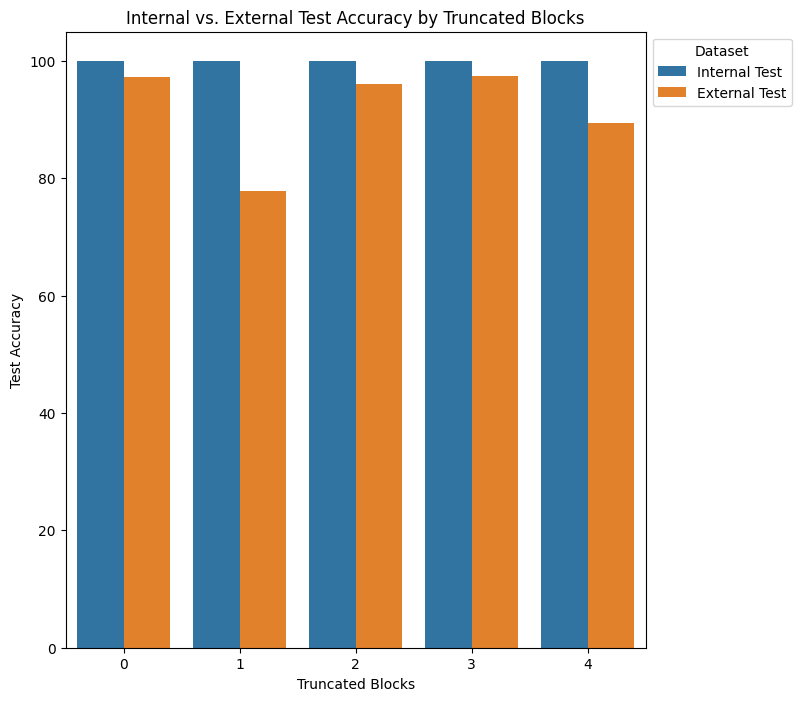

In [6]:
# Convert data into long format
df_melted = results_df.melt(id_vars=['truncated_layers'], 
                            value_vars=['single_test_acc', 'external_test_acc'], 
                            var_name='Dataset', value_name='Accuracy')

# Create figure and axis
fig3, ax3 = plt.subplots(figsize=(8, 8))  # Adjust figure size if needed

# Define custom colors
palette = {'single_test_acc': '#1f77b4', 'external_test_acc': '#ff7f0e'}

# Create bar plot with specified colors
sns.barplot(x='truncated_layers', y='Accuracy', hue='Dataset', data=df_melted, ax=ax3, palette=palette)

# Add plot labels
ax3.set_title("Internal vs. External Test Accuracy by Truncated Blocks")
ax3.set_ylabel("Test Accuracy")
ax3.set_xlabel("Truncated Blocks")

# Update legend labels
legend_labels = ['Internal Test', 'External Test']
handles, _ = ax3.get_legend_handles_labels()  # Get current legend handles
ax3.legend(handles=handles, labels=legend_labels, title="Dataset", bbox_to_anchor=(1.0, 1), loc='upper left')

# Adjust figure to prevent legend cut-off
fig3.subplots_adjust(right=0.85)  # Adjust the right margin

# Save to png
fig3.savefig("paper_figs/accuracy_barchart.png", format='png', bbox_inches='tight')  # bbox_inches='tight' also helps


## Replot Accuracy and Loss Trainign Plots

In [8]:

def plot_epoch_metrics(logs_path, metric, title, results_path, fname):

    training_logs = pd.read_csv(logs_path)

    fig, ax = plt.subplots()

    # Plot Training loss
    sns.lineplot(x='epoch', y=metric, data=training_logs)

    # Plot Validation loss
    sns.lineplot(x='epoch', y=f"val_{metric}", data=training_logs, color = '#ff7f0e')

    ax.set_title(title)

    # Define custom legend handles
    legend_handles = [
        plt.Line2D([0], [0], color='#1f77b4', lw=2, label='Training'),
        plt.Line2D([0], [0], color='#ff7f0e', lw=2, label='Validation')
    ]

    # Add the legend to the plot
    ax.legend(handles=legend_handles, title="")

    fig.savefig(f"{results_path}/{fname}", format='png')

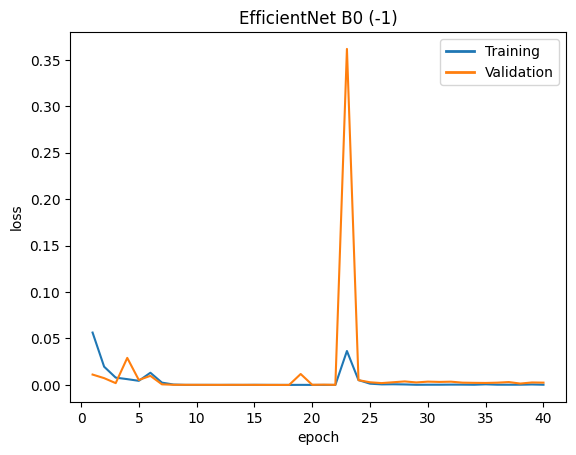

In [10]:
plot_epoch_metrics(logs_path="results/truncated_b0_act1_reduced_layers_1_2025-03-16_15-30/training_logs.csv",
                   metric="loss", title="EfficientNet B0 (-1)",
                   results_path="paper_figs", fname="b0_minus_1")

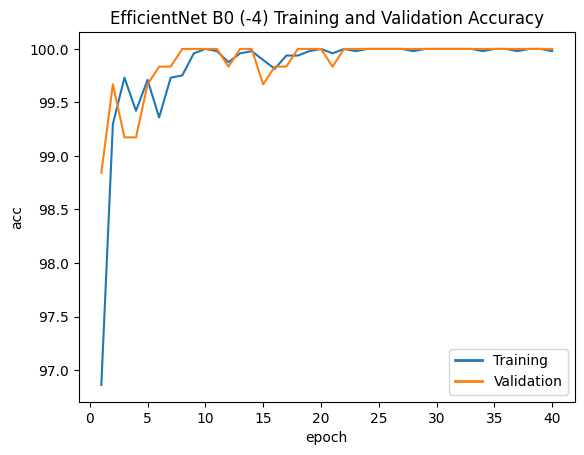

In [30]:
fig5, ax5 = plt.subplots()

# Plot Training loss
sns.lineplot(x='epoch', y='acc', data=best_model_training_logs)

# Plot Validation loss
sns.lineplot(x='epoch', y='val_acc', data=best_model_training_logs, color = '#ff7f0e')

ax5.set_title("EfficientNet B0 (-4) Training and Validation Accuracy")

# Define custom legend handles
legend_handles = [
    plt.Line2D([0], [0], color='#1f77b4', lw=2, label='Training'),
    plt.Line2D([0], [0], color='#ff7f0e', lw=2, label='Validation')
]

# Add the legend to the plot
ax5.legend(handles=legend_handles, title="")

fig5.savefig("paper_figs/epoch_acc.png", format='png')

## Save to PPTX

In [29]:


# Initialize PowerPoint presentation
prs = Presentation()

# Function to save the plot directly to a memory buffer
def save_plot_to_pptx(ax):
    buf = BytesIO()
    canvas = FigureCanvas(ax.figure)  # Create canvas from the figure
    canvas.print_png(buf)  # Save figure as PNG into the buffer
    buf.seek(0)  # Rewind the buffer to the start
    return buf

# Add plots to PowerPoint
for ax in [ax1, ax2, ax3, ax4, ax5]:  # Add your axes here
    slide = prs.slides.add_slide(prs.slide_layouts[6])  # Blank slide layout
    buf = save_plot_to_pptx(ax)  # Get plot from ax
    slide.shapes.add_picture(buf, Inches(1), Inches(1), height=Inches(5.5))  # Add to slide

# Save the PowerPoint file
prs.save('plots_presentation.pptx')
